In [40]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import modal
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# CONSTANTS

HF_USER = "ed-donner" # your HF name here! Or use mine if you just want to reproduce my results.
DATASET_NAME = f"{HF_USER}/pricer-data"
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
openai = OpenAI()

In [5]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [6]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [7]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [8]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [9]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [78]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/Users/ed/miniconda3/envs/llms/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
def vector(item):
    return model.encode([description(item)])

In [12]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [17]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [18]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [20]:
gpt_4o_mini_rag(test[1000])

40.97

In [21]:
test[1000]

<Rite In The Rain Weatherproof 4" x 6" Top Spiral Notebook Kit: Tan CORDURA Fabric Cover, 4" x 6" Green Notebook, and an Weatherproof Pen (No. 946-KIT) = $37.91>

In [31]:
Pricer = modal.Cls.lookup("pricer-service", "Pricer")
pricer = Pricer()

In [34]:
def proprietary(item):
    text = item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]
    return pricer.price.remote(text)

In [36]:
print(proprietary(test[1]))
print(gpt_4o_mini_rag(test[1]))

182.0
201.45


In [37]:
truths = []
proprietaries = []
rags = []
for i in tqdm(range(1000,1250)):
    item = test[i]
    truths.append(item.price)
    proprietaries.append(proprietary(item))
    rags.append(gpt_4o_mini_rag(item))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [13:17<00:00,  3.19s/it]


In [76]:
mins = [min(p,r) for p,r in zip(proprietaries, rags)]
maxes = [max(p,r) for p,r in zip(proprietaries, rags)]

X = pd.DataFrame({
    'Proprietary': proprietaries,
    'RAG': rags,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(truths)

In [79]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = ["Proprietary", "RAG", "Min", "Max"]

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Proprietary: 0.38
RAG: 0.12
Min: 0.11
Max: 0.39
Intercept=11.23


In [82]:
def ensemble(item):
    prop = proprietary(item)
    rag = gpt_4o_mini_rag(item)
    Xt = pd.DataFrame({
    'Proprietary': [prop],
    'RAG': [rag],
    'Min': [min(prop,rag)],
    'Max': [max(prop,rag)],
    })
    yt = lr.predict(Xt)
    return yt[0]

In [83]:
ensemble(test[0])

396.6927460035488

In [84]:
test[0].price

374.41

1: Guess: $396.69 Truth: $374.41 Error: $22.28 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $201.09 Truth: $225.11 Error: $24.02 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $48.95 Truth: $61.68 Error: $12.73 SLE: 0.05 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $372.60 Truth: $599.99 Error: $227.39 SLE: 0.23 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.58 Truth: $16.99 Error: $12.59 SLE: 0.28 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $28.70 Truth: $31.99 Error: $3.29 SLE: 0.01 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $128.59 Truth: $101.79 Error: $26.80 SLE: 0.05 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $357.44 Truth: $289.00 Error: $68.44 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $895.51 Truth: $635.86 Error: $259.65 SLE: 0.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $77.76 Truth: $65.99 Error: $11.77 SLE: 0.03 I

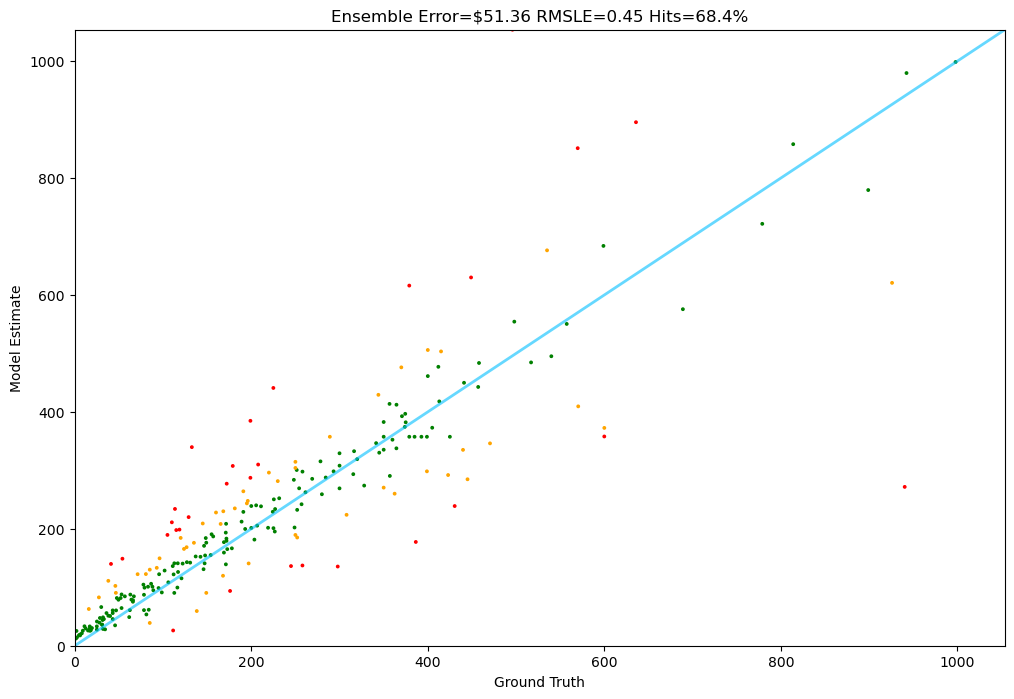

In [85]:
Tester.test(ensemble, test)

In [86]:
from sklearn.ensemble import RandomForestRegressor

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(vectors, prices)

In [92]:
def new_rf(item):
    text = item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]
    vector = model.encode([text])
    return max(0, rf_model.predict(vector)[0])

In [93]:
new_rf(test[0])

289.98609999999996

1: Guess: $289.99 Truth: $374.41 Error: $84.42 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $196.65 Truth: $225.11 Error: $28.46 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $213.42 Truth: $61.68 Error: $151.74 SLE: 1.51 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $364.84 Truth: $599.99 Error: $235.15 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $195.52 Truth: $16.99 Error: $178.53 SLE: 5.72 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $69.63 Truth: $31.99 Error: $37.64 SLE: 0.58 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $275.91 Truth: $101.79 Error: $174.12 SLE: 0.98 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $222.00 Truth: $289.00 Error: $67.00 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $275.46 Truth: $635.86 Error: $360.40 SLE: 0.70 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $182.72 Truth: $65.99 Error: $116.73 SLE

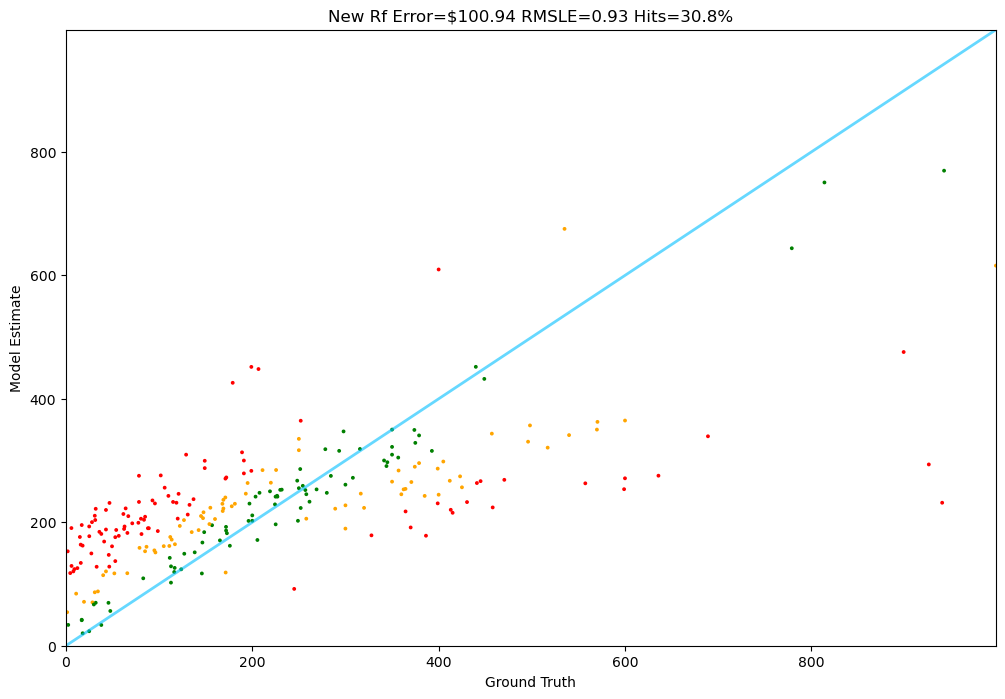

In [96]:
Tester.test(new_rf, test)

In [97]:
forests = []
for i in tqdm(range(1000,1250)):
    item = test[i]
    forests.append(new_rf(item))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 30.84it/s]


In [117]:
truths2 = []
proprietaries2 = []
rags2 = []
forests2 = []
for i in tqdm(range(1000,2000)):
    item = test[i]
    truths2.append(item.price)
    proprietaries2.append(proprietary(item))
    rags2.append(gpt_4o_mini_rag(item))
    forests2.append(new_rf(item))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:20<00:00,  2.96s/it]


In [126]:
mins2 = [min(p,r,f) for p,r,f in zip(proprietaries2, rags2, forests2)]
maxes2 = [max(p,r,f) for p,r,f in zip(proprietaries2, rags2, forests2)]



X2 = pd.DataFrame({
    'Proprietary': proprietaries2,
    'RAG': rags2,
    'Forest': forests2,
    'Min': mins2,
    'Max': maxes2,
})

# Convert y to a Series
y2 = pd.Series(truths2)

In [127]:
# Train a Linear Regression
np.random.seed(42)

lr2 = LinearRegression()
lr2.fit(X2, y2)

feature_columns = X2.columns.tolist()

for feature, coef in zip(feature_columns, lr2.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Proprietary: 0.46
RAG: 0.56
Forest: 0.04
Min: 0.06
Max: -0.12
Intercept=11.23


In [129]:
def ensemble2(item):
    prop = proprietary(item)
    rag = gpt_4o_mini_rag(item)
    r_f = new_rf(item)
    Xt2 = pd.DataFrame({
    'Proprietary': [prop],
    'RAG': [rag],
    'Forest': [r_f],
    'Min': [min(prop,rag, r_f)],
    'Max': [max(prop,rag, r_f)],
    })
    yt2 = lr.predict(Xt2)
    return yt2[0]

In [130]:
Tester.test(ensemble2, test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Forest
